# TP3

## Setup

### Imports

In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

### Directories

## Parte 1
A continuación, complementamos el trabajo hecho en el TP2 usando [la encuesta a
nivel hogares de la EPH](../input/EPH_usu_1er_Trim_2023_xlsx).

1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen
que pueden ser muy predictivas de pobreza y que sería muy útil incluir para
perfeccionar el ejercicio del TP2?

Además de las variables utilizadas en el TP2 referidas más a la condición del individuo. Dentro del subset de preguntas de la encuesta que refiere a condiciones del hogar y la vivienda, creemos que algunas podrían ser muy útiles a la hora de predecir la pobreza.

Sería interesante incluir variables que describan ciertar caraterísticas básicas de la vivienda que en caso de no estar cubiertas o de estarlo de manera muy precaria podrían ser predictorias de situación de pobreza. Como por ejemplo, las variables que indician si la vivienda está ubicada en zona de emergencia (IV12_3), ubicación del baño (IV9), conexión de agua (IV6), condición interior del techo (IV5), condición exterior del techo (V4), revestimiento del piso (IV3).  Otras relacionadas a características habitacionales del hogar como régimen de tenencia (II7) y la situación con respecto al uso y tenencia de baño (II9). Con respecto a las variables refereidas a estrategias del hogar, preguntas relacionadas a si el hogar recibe una ayuda de tipo social (V5), (V6) y (V7).

Recordemos que las variables utilizadas en el TP2 fueron 'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC'.


2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre
de 2023 (la base de hogares se llama [usu_hogar_T123.xls](//input/EPH_usu_1er_Trim_2023_xlsx/usu_hogar_T123.xlsx)). Importen los datos
de la encuesta de hogar y, al igual que en el TP2, conserven sólo las observaciones
que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o
del Gran Buenos Aires.

In [2]:
#Leemos y copiamos dicha base
dataframe = pd.read_excel('usu_hogar_T123.xlsx')
df_eph_hog = dataframe.copy()

#Nos quedamos solo con las Obs de CABA y GBA (Aglomerados: 32, 33)
df_eph_hog_BsAs = df_eph_hog[df_eph_hog['AGLOMERADO'].isin([32, 33])]


3. Unan la tabla de la encuesta individual con la de la encuesta de hogar.


In [3]:
#Leemos y copiamos dicha base
dataframe = pd.read_excel('usu_individual_T123.xlsx')
df_eph_indiv = dataframe.copy()
df_eph_indiv = df_eph_indiv[df_eph_indiv['AGLOMERADO'].isin([32, 33])]

#No hace falta filtrar por BsAs ya que con el match de codigo tmb lo hace
df_eph_BsAs = pd.merge(df_eph_indiv, df_eph_hog, on=['CODUSU','NRO_HOGAR'], how='inner', suffixes=('_H', '_I')) #solo se queda con las rows que en ambas bases tienen el mismo CODUSU, 'right' lo haria con hogar y NaN faltantes

#Testeamos si lo importamos correctamente:
with pd.option_context('display.max_columns', None): #nos permite temporalmente sacar la restriccion al limite de cols
  df_eph_BsAs.head(50) 
  



In [4]:
merged_df = df_eph_BsAs.drop(df_eph_BsAs.filter(like='_I').columns, axis=1)

4. Generen sus propias funciones para limpiar la base de datos o, si deciden utilizar funciones existentes en paquetes como numpy y pandas, mencionen cuáles usarán y de qué paquetes son.

In [5]:
def col_drop_if(drop_if_missings=False, other_criteria=[], df=merged_df):
  #dropear si cualquier valor de la lista esta en la columna
  if other_criteria:
    columns_to_drop = [col for col in df.columns if df[col].isin(other_criteria).any()]
    df = df.drop(columns=columns_to_drop)
  
  #dropear si hay missinings(valores vacios)
  if drop_if_missings:
    df.dropna(axis=1, inplace=True)

  return df

def drop_neg_obs(cols=[], df=merged_df):
  #transformamos la columna a valores numericos por las dudas
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  #(Checko si es neg) => Chequeo si algun valor es negativo => If si = True => Iniverto todo con "~" y me quedo solo convalores positivos
  df = df[~(df[cols] < 0).any(axis=1)]
  return df

def replace_rename_col(col=None, replace_dic={}, new_name=None, df=merged_df):
  df[col] = df[col].replace(replace_dic)
  if new_name:
    df = df.rename(columns={col: new_name})
  return df

def categorical_to_dummy(col=None, dummy_names_dic={}, keep_old_col=False, df=merged_df):
  #le agrega a las keys del diccionario la col+"_" como prefijo --> Nos permite ser mas robusto, por si hay valores que no estan en el diccionario, generandolas con nombre identificable igualmente
  complete_dummy_names_dic = {col+ '_' + key: value for key, value in dummy_names_dic.items()}
  #Genera las dummies a partir de los valores categoricos y renombra las dummies segun el diccionario dado
  new_dummies = pd.get_dummies(df[col], prefix=col, dtype=int).rename(columns=complete_dummy_names_dic)
  
  #si keep_old_col = False => drop col vieja
  if ~keep_old_col:
      df = df.drop(columns=[col])

  #le agrega las nuevas dummies al df
  df = pd.concat([df, new_dummies], axis=1)
  return df

5. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como así también decidan qué va- riables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones. 

En primer lugar, eliminamos las variables con valores faltantes. Analizando la base de datos vemos que las variables con missings tienen muchos de estos, por lo tanto, no son informativas incluirlas en nuestro modelo. Además exige darle un tratamiento a los missings y eliminarlos directamente, y no a las varibales que los contienen, nos haría perder una cantidad sustancial de observaciones. 

En segundo lugar, al igual que en el TP2, eliminamos las observaciones con posibles valores negativos ya que no hacen sentido y muestran, claramente, un error de medición. 

En tercer lugar, transformamos algunas variables categóricas en dummy puesto que es más informativo hacerlo a la hora de realizar estadisticas descriptivas o realizar los modelos. En particular, transformamos en dummy algunas de las variables mencionadas al principio del trabajo. 

Finalmente, transformamos algunas variables string en dummy, nuevamente, para que puedan ser tenidas en cuenta a la hora de realizar posibles estadísticias descriptivas o ser un predictor dentro del modelo.

In [ ]:
# Guardamos una copia del DataFrame original por precaución
df_eph_BsAs_clean = merged_df.copy()

# Eliminamos observaciones con valores negativos en columnas específicas
df_eph_BsAs_clean = drop_neg_obs(
cols=['CH06', 'P21', 'IPCF_H', 'ITF_H', 'PP08D1'],
df=df_eph_BsAs_clean)


# Eliminamos columnas con valores faltantes
df_eph_BsAs_clean = col_drop_if(
drop_if_missings=True,
other_criteria=[],
df=df_eph_BsAs_clean)

# Reemplazamos valores en la columna 'MAS_500_H' y renombramos la columna
df_eph_BsAs_clean = replace_rename_col(
col='MAS_500_H',
replace_dic={'S': 1, 'N': 0},
new_name='MAS_500',
df=df_eph_BsAs_clean)

# Reemplazamos valores en la columna 'IV5' y renombramos la columna
df_eph_BsAs_clean = replace_rename_col(
col='IV5', replace_dic={'1': 1, '2': 0},
new_name='techo_revestido',
df=df_eph_BsAs_clean)

# Convertimos columnas categóricas en columnas de variables dummy
categorical_list = [
{'col': 'IV3',
'dummy_names_dic': {
'1': 'pisos_revestido',
'2': 'pisos_cemento',
'3': 'pisos_sin_revestir',
'4': 'pisos_sin_especificar'
}
},
{'col': 'IV9',
'dummy_names_dic': {
'1': 'baño_adentro',
'2': 'baño_afuera',
'3': 'baño_sin'
}
},
]

for i in range(0, len(categorical_list)):
c = categorical_list[i]
df_eph_BsAs_clean = categorical_to_dummy(
col=c['col'],
dummy_names_dic=c['dummy_names_dic'],
df=df_eph_BsAs_clean)

# Muestra el DataFrame resultante con todas las transformaciones
with pd.option_context('display.max_columns', None, 'display.max_rows', 10):
display(df_eph_BsAs_clean)

6. Presenten estadísticas descriptivas de cinco variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir pobreza. 

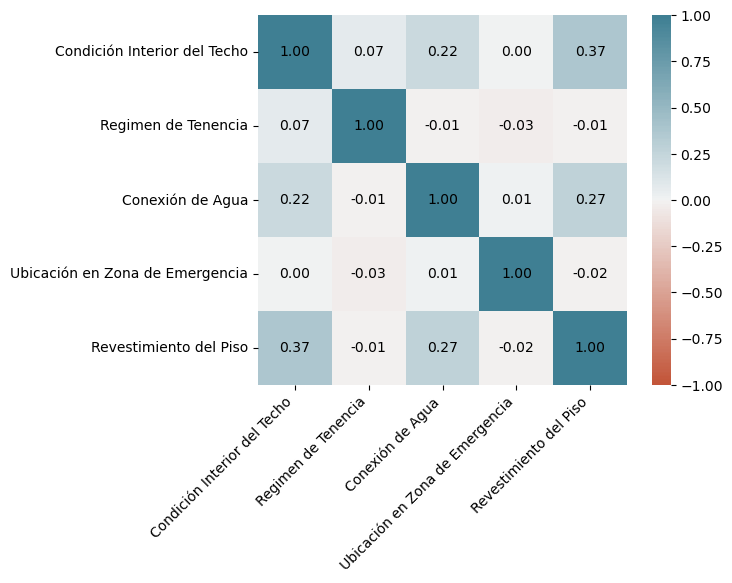

In [7]:
#Mapa de correlaciones entre variables elegidas

import seaborn as sns

datos_temporal = df_eph_BsAs_clean.copy()

# Luego, renombra la columna en la copia
datos_temporal.rename


# Para restaurar el nombre original, puedes eliminar la columna renombrada de 'datos_temporal'

datos_temporal.rename(columns={'IV5': 'Condición Interior del Techo'}, inplace=True)
datos_temporal.rename(columns={'II7': 'Regimen de Tenencia'}, inplace=True)
datos_temporal.rename(columns={'IV6': 'Conexión de Agua'}, inplace=True)
datos_temporal.rename(columns={'IV12_3': 'Ubicación en Zona de Emergencia'}, inplace=True)
datos_temporal.rename(columns={'IV3': 'Revestimiento del Piso'}, inplace=True)

# Creamos una lista de las variables que queremos incluir en la matriz de correlaciones

variables_a_incluir= ['Condición Interior del Techo', 'Regimen de Tenencia', 'Conexión de Agua','Ubicación en Zona de Emergencia',  'Revestimiento del Piso']


# Crear un DataFrame temporal con las variables seleccionadas
datos_temporal = datos_temporal[variables_a_incluir]

#Creamos la matriz de correlaciones
corr = datos_temporal.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)


# Usamos un for anidado para recorrer las filas y columnas de la matriz de correlación y agregar etiquetas a las celdas del mapa de calor.
for i in range(len(variables_a_incluir)):
    for j in range(len(variables_a_incluir)):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Establecer las etiquetas de las variables en el eje x
ax.set_xticklabels(
    variables_a_incluir,
    rotation=45,
    horizontalalignment='right'
)

#Guardamos el gráfico
plt.savefig("mapa_de_correlaciones.png", dpi=300, bbox_inches='tight')

#Eliminamos los datos temporales
del datos_temporal

In [8]:
#Resumen de estadisticas descriptivas

variables_elegidas = ['IV5', 'II7', 'IV6', 'IV12_3', 'IV3']
estadisticas_descriptivas = df_eph_BsAs_clean[variables_elegidas].describe(include='all')
print(estadisticas_descriptivas)


               IV5          II7          IV6       IV12_3          IV3
count  6388.000000  6388.000000  6388.000000  6388.000000  6388.000000
mean      1.163118     1.968378     1.028021     1.994678     1.130714
std       0.369503     1.619399     0.174275     0.072767     0.356086
min       1.000000     0.000000     1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000     2.000000     1.000000
50%       1.000000     1.000000     1.000000     2.000000     1.000000
75%       1.000000     3.000000     1.000000     2.000000     1.000000
max       2.000000     9.000000     3.000000     2.000000     4.000000


Las variables que seleccionamos son las de condición del interior del techo, régimen de tenencia (que indica su condición en cuanto a la tenencia del domicilio, alquiler/propietario/etc.), conexión de agua, ubicación en zona de emergencia (que indica si la vivienda se encuentra dentro de una villa de emergencia) y revestimiento del piso. Nos parece que estas cinco variables son clave para analizar la situación de quienes residan en la vivienda. 
Podemos observar que condición interior del techo tiene una relación positiva  de 0.36 con revestimiento del piso, esto tiene sentido ya que es probable que las condiciones de las distintas partes de la vivienda sean parecidas. El régimen de tenencia tiene correlación negativa y baja con revestimiento de piso, ubicación en zona de emergencia y conexión de agua. Tiene una correlación positiva de 0.05 con condición interior del techo. 
Conexión de agua tiene relación positiva con revestimiento del piso (0.27) y condición interior del techo (0.21). Esto nuevamente habla sobre la condición de la vivienda. 
Finalmente, zona de emergencia tiene muy poca correlación con el resto de las variables. 
Esta matriz lo que nos indica es que la calidad de la vivienda suele ser uniforme, pero que las condiciones externas (como régimen de propiedad y zona) no están tan conectadas.

7. Repitan el inciso 1.2.f del TP2 para construir la columna adulto equiv y la columna ad equiv hogar (pueden utilizar su código del TP2). 

In [9]:
# Definir la tabla de equivalencias necesarias eneréticas según edad y sexo
equiv_energ = { 
  1 : { #si es 1 = Varón
    (0, 0.99): 0.35, #0.35 es el valor de un varón menor a 1 año
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.79,
    (11, 11): 0.82,
    (12, 12): 0.85,
    (13, 13): 0.9,
    (14, 14): 0.96,
    (15, 15): 1,
    (16, 16): 1.03,
    (17, 17): 1.04,
    (18, 29): 1.02,
    (30, 45): 1,
    (46, 60): 1,
    (61, 75): 0.83,
    (75, 200): 0.74
  },
  2 : { #si es 2 = Mujer
    (0, 0.99): 0.35,
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.7,
    (11, 11): 0.72,
    (12, 12): 0.74,
    (13, 13): 0.76,
    (14, 14): 0.76,
    (15, 15): 0.77,
    (16, 16): 0.77,
    (17, 17): 0.77,
    (18, 29): 0.76,
    (30, 45): 0.77,
    (46, 60): 0.76,
    (61, 75): 0.67,
    (75, 200): 0.63
    }
}

#Función para calcular 'adulto_equiv' basado en la edad y el sexo
def calculate_adulto_equiv(row):
  age = row['Edad'] #Obterner valor de "edad" del la row del df
  sex = row['CH04'] #Obterner valor de "edad" del la row del df
  
  if sex in equiv_energ: #Verificar,por las dudas, si el sexo está en el dic
     # Loopear los rangos de edad y valores en el dic
    for (start, end), value in equiv_energ[sex].items():
        if start <= age <= end: 
            return value #Devolver el valor correcto, si la edad está en el rango
  else: 
    print(f'Not found [age:{age}, sex:{sex}]')
  
  return 0 #devolver 0 como valor predeterminado

df_eph_BsAs_clean.rename(columns={'CH06': 'Edad'}, inplace=True)

df_eph_BsAs_clean['adulto_equiv'] = df_eph_BsAs_clean.apply( #guarda el resultado de la funcion
    lambda row: calculate_adulto_equiv(row), axis=1)#Aplica calculate_adulto_equiv a cada fila del df

#Obtener 'ad_equiv_hogar' para cada row del df con groupby y transform
df_eph_BsAs_clean['ad_equiv_hogar'] = df_eph_BsAs_clean.groupby('CODUSU')['adulto_equiv'].transform('sum')
#Por el problema: base2 & floating point -> redondeamos a 2 decimales(estandar en esta base de datos)
df_eph_BsAs_clean['ad_equiv_hogar'] = df_eph_BsAs_clean['ad_equiv_hogar'].round(2)

8. Repitan el inciso 1.3 y 1.4 del TP2 para dividir la base en dos dataframes donde: uno conserve las personas que no reportaron ITF (dataframe llamado 2 respondieron) y otro conserve a las personas que no reportaron ITF (llama- do norespondieron). Además, agreguen a la base respondieron una colum- na llamada ingreso necesario que sea el producto de la canasta básica por ad equiv hogar. 

In [10]:
#Traemos el codigo del TP2


# Generamos una dummy llamada respondieron, si indicaron un ingreso mayor a 0 se les asigna un 1
df_eph_BsAs_clean['respondieron'] = (df_eph_BsAs_clean['ITF_H'] > 0).astype(int)


# Sumamos para ver cuanta gente respondio
total_respondieron = df_eph_BsAs_clean['respondieron'].sum()

print(total_respondieron)

# Repetimos para los que no respondieron (es decir los que reportaron un ingreso = 0)

df_eph_BsAs_clean['norespondieron'] = (df_eph_BsAs_clean['ITF_H'] == 0).astype(int)

total_norespondieron = df_eph_BsAs_clean['norespondieron'].sum()

print(total_norespondieron)

# Creamos la base 'respondieron'

respondieron = df_eph_BsAs_clean[df_eph_BsAs_clean['ITF_H'] > 0]

# Creamos la base 'norespondieron'

norespondieron = df_eph_BsAs_clean[df_eph_BsAs_clean['ITF_H']==0]

# 1.4

# Creamos una nueva variable llamada ingreso necesario, que contiene la operacion exigida por la consigna

respondieron.loc[:,"ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 57371.05


print(respondieron['ingreso_necesario'])

4181
2207
0        86056.5750
1        86056.5750
2       140559.0725
3       140559.0725
4       140559.0725
           ...     
7611    219157.4110
7612    141132.7830
7613    141132.7830
7614    141132.7830
7615     36143.7615
Name: ingreso_necesario, Length: 4181, dtype: float64


C:\Users\juliv\AppData\Local\Temp\ipykernel_13408\1515416782.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:,"ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 57371.05


9. Agreguen a la base respondieron una columna llamada pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita esa familia y 0 en caso contrario. 

In [11]:
#Traemos el codigo del TP2
# Creamos una nueva columna llamada pobre, que contiene un 1 si la persona tiene un ingreso menor al necesario

respondieron['pobre'] = (respondieron['ITF_H'] < respondieron['ingreso_necesario']).astype(int)

C:\Users\juliv\AppData\Local\Temp\ipykernel_13408\2794180298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobre'] = (respondieron['ITF_H'] < respondieron['ingreso_necesario']).astype(int)


10. En el TP2 calcularon los individuos bajo la línea de pobreza. Sin embargo, cuando se habla de pobreza el número más utilizado es el de la tasa de hogares bajo la línea de pobreza. Para calcularlo, utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Se asemeja al que reporta el INDEC en sus informes?

In [12]:
#Traemos el codigo del TP2

# Contamos la cantidad de pobres
cantidad_hogares_pobres = respondieron['pobre'].sum()
proporción_hogares_pobres = cantidad_hogares_pobres/len(respondieron['pobre'])

print(cantidad_hogares_pobres)
print(proporción_hogares_pobres)

NameError: name 'cantidad_pobres' is not defined

La tasa que reporta el INDEC en sus informes para el GBA es de 30.3% de los hogares pobres. Nuestra estimación nos da un porcentaje de hogares pobres de 7 puntos más (37.4%). Es decir, estamos sobreestimando la cantidad de hogares pobres en Argentina.

## Parte 2

In [ ]:

#from ISLP import load_data
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm     

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import KFold





1. Escriban una función, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X train, y train, X test, y test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar la matriz de confusión, las curvas ROC y los valores de AUC y de accuracy score de cada método). El output de la función debe ser una colección con las métricas evaluadas.

In [36]:
def evalua_metodo(modelo, X_train, X_test, Y_train, Y_test):
    '''
    Esta función toma como argumentos (como lo indica la consigna) un modelo y los correspondientes datos. Para la función evaluar
    cada modelo, especificamos distintas métricas (utilizamos las mismas que en el TP2). Le pedimos que el producto de la función
    sea un Data Frame que resuma estas metricas para el/los modelo/s que vayamos a evaluar.
    '''
 
    model = modelo
    model.fit(X_train, Y_train)
    y_pred_modelo = model.predict(X_test)
    matriz_confusion = confusion_matrix(Y_test, y_pred_modelo)
    tn, fp , fn, tp = confusion_matrix(Y_test, y_pred_modelo).ravel()
    specificity = tn / (tn+fn)
    accuracy = accuracy_score(Y_test, y_pred_modelo)
    recall= recall_score(Y_test, y_pred_modelo)
    precision = tp/(tp + fp)
    auc= roc_auc_score(Y_test, y_pred_modelo)
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_modelo)
    np.set_printoptions(suppress = True)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='')
    display.plot()  
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.show() 
    
    ecm = mean_squared_error(Y_test, y_pred_modelo)
    
    df_metrics = pd.DataFrame({'modelo': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm], 'precision': [precision], 'recall': [recall], 'specificity': [specificity]})

    return df_metrics


2. Escriban una función, llamada cross validation, que realice validación cru-
zada con k iteraciones (k -fold CV), llamando a la función del inciso anterior en
cada una, pero para las k distintas particiones. La función debe recibir como
argumentos el modelo, el valor de k y un dataset (es decir, sólo X e y). Pueden
ayudarse con la función KFold para generar las particiones necesarias.


In [14]:
def cross_validation(modelo, K, X, Y, standard=True):
    '''
    Esta función toma como argumentos un modelo, K que es la cantidad de particiones que queremos hacerle a la muestra, los 
    respectivos datos X e Y y un arguemnto para standarizar nuestros regresores. Primero, llamamos a la función Kfold para
    realizar la particiones, luego  iteramos a través de las particiones y realizamos la validación cruzada. Luego llamamos,
    a la función evalua_metodo para evaluar los distintos modelos surgidos a partir de las particiones. De todas las metricas,
    definidas en la función evaluar_metodo nos quedamos con el ecm, tambien calculamos el ecm_promedio que es la media del ecm
    para todas las particiones. El return de la funcion es una lista con los ecm de cada particion y el promedio de todas estas.
    '''
    ecm_scores = []
        
    sc = StandardScaler()
    kf = KFold(n_splits=K, shuffle=True, random_state=63)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        if standard:
                X_train = sc.fit_transform(X_train)
                X_test = sc.transform(X_test)
          

        df_metrics = evalua_metodo(modelo, X_train, X_test, Y_train, Y_test)
        ecm = df_metrics['ecm'].values[0] 
        ecm_scores.append(ecm)

    ecm_promedio = np.mean(ecm_scores)

    return ecm_scores, ecm_promedio



3. Escriban una función, llamada evalua config que reciba una lista de configuraciones de hiperparámetros1 (los distintos valores a probar como hiper
parámetros podrian codificarse en diccionarios de Python) y utilizando la función cross validation obtenga el error2 promedio para cada configuración.
En scikit-learn, muchos métodos llaman penalty al método de regularización y C a la inversa
del hiperparámetro λ.
Utilicen la medición del error que prefieran. Una opción ser ́ıa el Error Cuadrático Medio.
Finalmente, la función debe devolver la configuración que genere menor error3.


In [26]:
def evalua_config(hiperparametros, X, Y, K):
    '''
    Esta funcion lo que hace es que para un/os valor/es para los hiperparametros lambda y una penalidad (Ridge = l2, Lasso = l2
    , elastic net = elastic net) corra un modelo Logit y le haga una validación cruzada (llamando la función definida 
    previamente). Finalmente en una lista almacena el ecm promedio para cada modelo posible (partición-penalidad-hiperparametro)
    y los almacena en un diccionario. Donde la key es el hiperparametro y el value es el ecm_promedio. Finalmente, calculamos 
    para cada hiperparamtetro, cual es el que tiene el menor ecm_promedio. La función nos  devuelve este diccionario y el 
    mejor hiperparametro.
    '''
    errores_promedio = {}
    
    for hiperparametro in hiperparametros:

        C = 1 / hiperparametro
        modelo = LogisticRegression(C=C, penalty=penalty, solver= 'saga', max_iter = 100)

        ecm_scores, ecm_promedio = cross_validation(modelo, K, X, Y, standard=True)

        errores_promedio[hiperparametro] = ecm_promedio

    mejor_hiperparametro = min(errores_promedio, key=errores_promedio.get)

    return errores_promedio, mejor_hiperparametro


4. Escriban una función llamada evalua multiples metodos que les permita im-
plementar los siguiente métodos con los hiperparámetros que ustedes elijan.
Para la regresión log ́ıstica, asegúrense de que esta función utilice su función
evalua config para optimizar el λ de la regularización. Finalmente, el output
de la función debe ser una tabla donde las columnas sean las métricas que hayan
evaluado (las que hayan incluido en la función evalua metodo) y las filas sean
los modelos (con su configuración de hiperparámetros asociada) que hayan co-
rrido. Asegúrense de que la tabla incluya una columna con nombre del modelo
y el valor de los hiperparámetros/configuración:4
Regresión log ́ıstica
Análisis de discriminante lineal
KNN

In [ ]:
def evalua_multiples_metodos(K, X_train, X_test , Y_train, Y_test, X, Y, hiperparametro, k_knn,  modelos = ['Logit', 'KNN', 'LDA']
):
    '''
    Esta función lo que hace es que para una lista de posibles modelos, le aplica la función evalua_metodos a cada uno de los
    elementos de la lista. Luego genera una lista de resultados asociados a lo que hace la función evalua_metodo y los adjunta 
    en una tabla que dicho sea de paso es el return del modelo en el que podemos aprecias distintas metricas para cada modelo.
    '''
    tabla_comparativa = pd.DataFrame(columns=["Modelo", "Hiperparametro","Accuracy", "AUC", "Precision", "Specificity", "Recall", "ECM"])
    for modelo in modelos:
        if modelo == 'Logit':
             #hiperparametro landa
            metricas_log= evalua_metodo(LogisticRegression(C=1/hiperparametro, penalty=penalty, solver = 'saga'), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, hiperparametro, metricas_log['accuracy'][0], metricas_log['auc'][0], metricas_log['precision'][0], 
                       metricas_log['specificity'][0],  metricas_log['recall'][0],  metricas_log['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'KNN':
            metricas_knn = evalua_metodo(KNeighborsClassifier(n_neighbors=k_knn), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, k_knn, metricas_knn['accuracy'][0], metricas_knn['auc'][0], metricas_knn['precision'][0], 
                       metricas_knn['specificity'][0],  metricas_knn['recall'][0],  metricas_knn['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados

        elif modelo == 'LDA':
            metricas_lda = evalua_metodo(LinearDiscriminantAnalysis(), X_train, X_test, Y_train, Y_test)
            resultados = [modelo, 'NA', metricas_lda['accuracy'][0], metricas_lda['auc'][0], metricas_lda['precision'][0], 
                       metricas_lda['specificity'][0],  metricas_lda['recall'][0],  metricas_lda['ecm'][0]]
            tabla_comparativa.loc[len(tabla_comparativa)] = resultados


    return(tabla_comparativa)

## Parte 3

1. Eliminen de ambas bases (respondieron, norespondieron) todas las variables
relacionadas a ingresos (en el archivo Dise ̃no de bases y estructura ver las ca-
tegor ́ıas: ingresos de la ocupaci ́on principal de los asalariados, ingresos de la
ocupaci ́on principal, ingresos de otras ocupaciones, ingreso total individual, in-
gresos no laborales, ingreso total familiar, ingreso per c ́apita familiar). Eliminen
tambi ́en las columnas adulto equiv, ad equiv hogar e ingreso necesario.
Establezcan a la variable pobre como su variable dependiente (vector y). El
resto de las variables ser ́an las variables independientes (matriz X). Dependien-
do de la funci ́on que usen, no se olviden de agregar la columna de 1 cuando sea
necesario.


In [17]:
#Hacemos una lista con las variables referidas a ingresos y demas que exige la consiga.

columnas_a_eliminar = ['PP06A', 'PP06C', 'PP06D', 'PP06E', 'PP06H', 'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 
                       'PP08J3', 'P21', 'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCOCUR', 'PDECOCUR', 'ADECOCUR', 'PONDIIO', 
                       'TOT_P12', 'P47T', 'DECINDR', 'IDECINDR', 'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR', 'ADECINDR', 
                       'PONDII', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'T_VI', 'ITF',
                       'V12_M', 'V18_M', 'V19_AM', 'V21_M','DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'IDECCFR', 'RDECCFR',
                       'GDECCFR', 'PDECCFR', 'ADECCFR', 'PONDIH', 'adulto_equiv','ad_equiv_hogar','ingreso_necesario', 'CODUSU', 'CH05']

#Reescribimos los dataframes con las variables que nos interesan
columnas_a_mantener = [col for col in respondieron.columns if col not in columnas_a_eliminar]

columnas_a_mantener2 = [col for col in norespondieron.columns if col not in columnas_a_eliminar]

respondieron = respondieron[columnas_a_mantener]
norespondieron = norespondieron[columnas_a_mantener2]

In [18]:
#Definimos la variable dependiente.
Y = respondieron['pobre']
X_int = respondieron.copy()

# Eliminamos pobre de respondieron para que no sea la variable a predecir y predictora a la vez. 
if 'pobre' in X_int.columns:
    X_int = X_int.drop('pobre', axis=1) 
    
#Agregamos la columna de unos.
X = sm.add_constant(X_int)

#Estandarizamos las X

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

#Partimos la muestra en entrenamiento y test.
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state= 211)

2. Corran la funci ́on evalua multiples metodos con la base respondieron. En
los pr ́oximos incisos profundizaremos en la tarea de regularizaci ́on, pero en este
ejercicio prueben al menos un hiperpar ́ametro para regularizar y al menos un
valor de λ.
3Consejo: cuanto m ́as gen ́erica construyan la funci ́on, luego podr ́a ser utilizada en m ́as situacio-
nes. Por ahora, la usaremos solo para buscar el λ  ́optimo cuando utilicemos regularizaci ́on.
4Pista: para la regresi ́on log ́ıstica, cuando incluyan regularizaci ́on observen que deber ́an correr
la funci ́on evalua metodo dos veces. Una para optimizar los hiperpar ́ametros (con un set de datos
para train y otro para validaci ́on) y otra para obtener las m ́etricas con el hiperpar ́ametro  ́optimo
(con un set de datos para train y otro para test).

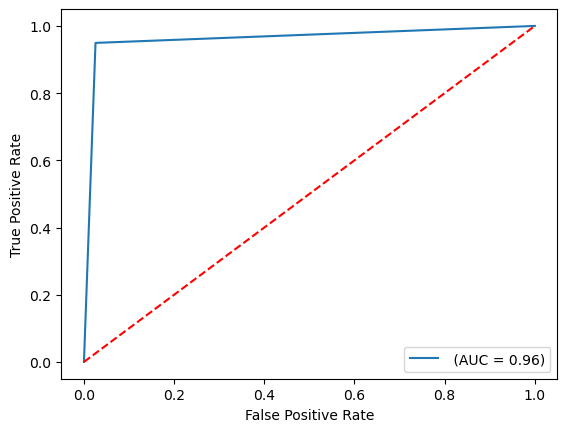

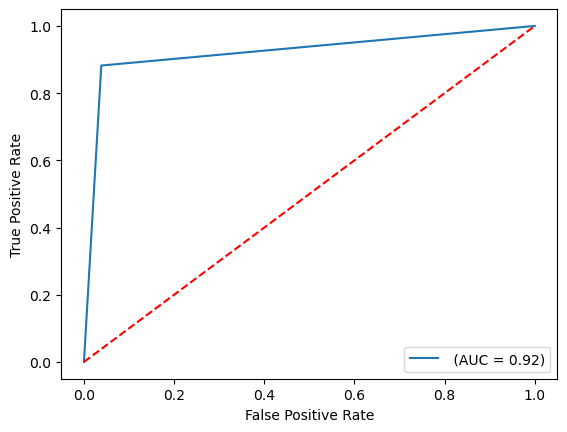

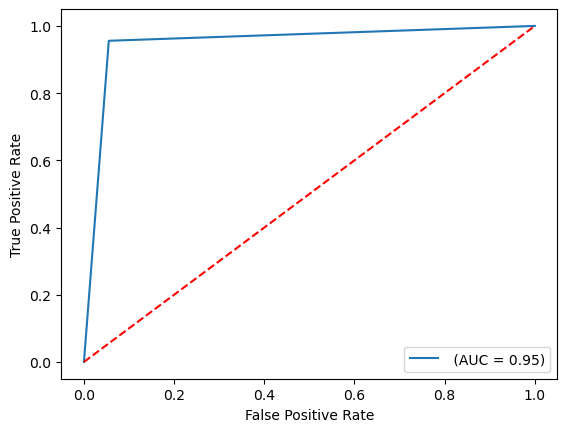

,Modelo,Hiperparametro,Accuracy,AUC,Precision,Specificity,Recall,ECM
0,Logit,10,0.964940,0.961916,0.957537,0.969388,0.949474,0.035060
1,KNN,3,0.931474,0.921822,0.933185,0.930521,0.882105,0.068526
2,LDA,NA,0.949004,0.950331,0.913481,0.972296,0.955789,0.050996


In [19]:
#Corremos la funcion evalua_multiples metodos. #Definimos 5 particiones para la validación cruzada, 3 vecinos cercanos para el 
# metodo de vecinos cercanos y que el valor de lambda es igual a 10. Usaremos una regularización Ridge. En los proximos incisios
#profundizamos más acerca de la regularización. 

K=5
hiperparametro = 10
k_knn = 3
penalty = 'l2'

evalua_multiples_metodos(K, X_train, X_test , Y_train, Y_test, X, Y, hiperparametro, k_knn,  modelos = ['Logit', 'KNN', 'LDA'])

Vemos que el modelo Logit es el mejor, ya que de acuerdo a las métricas con la que evaluamos el modelo, es el que mejor performance tiene. En particular, es el modelo con mayor accuracy, más AUC (más cerca de nuestro escenario ideal de que sean todos verdaderos positivos y verdaderos negativos), mejor rpecisión y menor error cuadrático medio. El segundo mejor modelo
es el análisis discriminante lineal que es el que tienen mejor recal y especificidad, mientras que el peor modelo es el de Vecinos Cercanos que tiene el pero desempeño en casi todas las métricas.

3. Expliquen c ́omo elegir ́ıan λ por validaci ́on cruzada. Detallen por qu ́e no usar ́ıan
el conjunto de prueba (test) para su elecci ́on.


Uilizamos cross-validation con el objetivo de minimizar el error de predicción de nuestro modelo fuera de la muestra. Nosotros tenemos un set de distintos valores de \lambda, entonces a partir de los distintos valores del hiperparametro, y haciendo una particion de la muestra en K partes probamos distintos lambdas en distintas particiones en la que dejamos al azar una parte diferente para testear. En base a todas estas combinaciones de particiones y \lambda elegimos aquel con mejor error de pronóstico. 

No utilizamos los datos de test para la elección porque podemos generar overfitting a la muestra, es decir que seamos muy bueno intra muestra predeciendo pero muy malo fuera de ella. Esto se debe a que sesgamos nuestros predictores y que aumente también la varianza de estos. 

4. En validaci ́on cruzada, ¿cu ́al es el problema de usar un k muy peque ̃no y uno
muy grande? Cuando k = n (con n el n ́umero de muestras), ¿cu ́antas veces se
estima el modelo?


En el caso extremo, si K=1 estamos prediciendo con toda la muestra no estamos partiendo en test set y train set. Mientras k sea más chico, es más probable los resultados seam más sensible a las poquitas particiones que hacemos. 

Por otro lado, mientras k sea más grande, la estimación se hace menos precisa pero mejora el poder predictivo fuera de la muestra. En el extremo, si k=n estamos estimandolo n veces con n-1 datos, es decir, estamos haciendo un proceso de leave one out, dejamos una observación afuera. Otra cuestion a tener en cuenta, es que mientras más grande es la particiones (en el extremo n), a nivel computacional se vuelve cada vez más intensivo. 

5. Realicen un barrido en λ = 10n con n ∈ {−5, −4, −3 . . . , +4, +5} y utilicen 10
fold CV para elegir el λ  ́optimo en regresi ́on logistica con Ridge y con LASSO.
¿Qu ́e λ seleccion ́o en cada caso? Generen box-plots mostrando la distribuci ́on
del error de predicci ́on para cada λ. Cada box debe corresponder a un valor de λ
y contener como observaciones el error medio de validaci ́on para cada partici ́on.
Adem ́as, para la regularizaci ́on LASSO, genere un box-plot similar, pero ahora
graficando la proporci ́on de variables ignoradas por el modelo en funci ́on de λ,
es decir la proporci ́on de variables para las cuales el coeficiente asociado es cero.


In [20]:
def evalua_metodo(modelo, X_train, X_test, Y_train, Y_test):
    model = modelo
    model.fit(X_train, Y_train)
    y_pred_modelo = model.predict(X_test)
    ecm = mean_squared_error(Y_test, y_pred_modelo)
    
    df_metrics = pd.DataFrame({'modelo': [model],'ecm':[ecm]})

    return df_metrics

#Aclaración: esta lejos de ser lo optimo tener que editar la funcion evalua_metodo. Pero dado lo que tarda en correr el punto 5. La reducimos para intentar optimizar el proces0.

In [27]:
hiperparametros = 10**np.linspace(-6,6,11) #definimos la cantidad de hiperparametros a probar.
K=10 #definimos la cantidad de particiones de la muestra
#l1 es una penalidad lasso y l2 es una penalidad Ridge. Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
penalty='l1' 
Lasso = evalua_config(hiperparametros, X, Y, K) #llamamos la funcion para una regularización Lasso

penalty='l2'
Ridge= evalua_config(hiperparametros, X, Y, K) #llamamos la funcion para una regularización Ridge

C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

In [28]:
print(Lasso)

print(Ridge)

#El valor óptimo tanto para Lasso como para Ridge es lambda = 10.

({1e-05: 0.04066015004967398, 0.0001: 0.04066015004967398, 0.001: 0.04066015004967398, 0.01: 0.04066015004967398, 0.1: 0.04042091559991322, 1.0: 0.04018168115015244, 10.0: 0.038267805552066325, 100.0: 0.046399492982836785, 1000.0: 0.19204759566523164, 10000.0: 0.37455321967317945, 100000.0: 0.37455321967317945}, 10.0)
({1e-05: 0.04042091559991322, 0.0001: 0.04042091559991322, 0.001: 0.04066015004967398, 0.01: 0.04042091559991321, 0.1: 0.04066015004967398, 1.0: 0.04066015004967398, 10.0: 0.0397037832159048, 100.0: 0.040422057530461, 1000.0: 0.05692409587648879, 10000.0: 0.12149969738840485, 100000.0: 0.37455321967317945}, 10.0)


6. En el caso del valor  ́optimo de λ para LASSO encontrado en el inciso anterior,
¿qu ́e variables fueron descartadas? ¿Son las que hubieran esperado? ¿Tiene re-
laci ́on con lo que respondieron en el inciso 1 de la Parte I?


In [29]:
#Corremos el modelo con una regularización Ridge (penalty ya esta por default definido para Ridge) y un lambda = 10.
#Aclaración con respecto solver, es una opcion dentro de LogRegression que tenemos que utilizar para que corra. 
modelo = LogisticRegression(C=1/10, penalty=penalty, solver="saga", max_iter=1000).fit(X_train, Y_train)
pred_6 = modelo.predict(X_test)
ecm_6= mean_squared_error(Y_test, pred_6)


C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
#Como X e Y son matrices para saber el nombre de las variables descartadas, volvemos al dataframe a partir del cual la definimos
#que es respondieron y extraemos el nombre de las columnas.El orden de las variables en la lista coincide con el de los 
# coeficientes.

with pd.option_context("display.max_columns", None,"display.max_rows", None):
    print(list(respondieron.columns))


['ANO4_H', 'TRIMESTRE_H', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'MAS_500', 'AGLOMERADO_H', 'PONDERA_H', 'CH03', 'CH04', 'Edad', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH15', 'CH16', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'GDECOCUR', 'ITF_H', 'DECIFR_H', 'RDECIFR_H', 'GDECIFR_H', 'ADECIFR_H', 'IPCF_H', 'DECCFR_H', 'RDECCFR_H', 'GDECCFR_H', 'ADECCFR_H', 'PONDIH_H', 'REALIZADA', 'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II2', 'II3', 'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II5_1', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'V1', 'V2', 'V21', 'V22', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19_A', 'V19_B', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4', 'REGION_H_1', 'respondieron', 'norespondi

In [31]:
#Extraemos los coeficientes del modelo recien corrido en una lista
coefs = list(modelo.coef_)
print(coefs[0])

[ 0.          0.          0.15769223  0.08895463  0.09246788  0.
  0.52374047  0.23567529 -0.01864394 -0.17731043 -0.51779727 -0.1188829
  0.02488616 -0.12327439  0.06731641  0.00696361  0.01278718  0.12197372
 -0.07078371 -0.04116316 -0.0286209  -0.06338615  0.00293689  0.08177866
  0.11651938  0.0105734  -0.08138591 -0.04094547 -0.09910867  0.03740657
 -0.03932068  0.02774361 -0.03054783 -0.01647125 -0.1073919  -0.17900316
 -0.53438155 -0.56295551 -0.48554774 -0.57977698 -0.08425113 -1.24075143
 -1.21165782 -1.14297512 -1.37532674 -0.18213429  0.          0.14117368
  0.30358873  0.21796831 -0.20482336 -0.17201662  0.09084743  0.02477255
 -0.15879684 -0.05825221  0.03186122 -0.09581874 -0.10041714 -0.05280578
  0.07775042  0.07646338  0.24036427  0.06854492 -0.02192672 -0.05017649
  0.01671553 -0.085692   -0.01990498  0.10807044 -0.13420287  0.05772689
  0.15201677 -0.14905326  0.07315434 -0.2585828   0.3119145  -0.03654236
 -0.11980912  0.04531326  0.12346759 -0.00551512 -0.2170894 

In [32]:
#Unimos la lista del nombre de las variables con los coeficientes. Notar que pobre que es la variable dependiente está 
# correctamente excluida de la lista de coeficientes por lo que no tendrá una contrapartida en la lista de variables. 

vars = list(respondieron.columns)
coefs = list(modelo.coef_[0])

used_vars_pairs = []
used_vars = []
for i in range(0,len(coefs)):
  beta = coefs[i]
  if beta == 0:
    used_vars_pairs.append({'var':vars[i],'coef':beta})
    used_vars.append(vars[i])
    
print(used_vars)

['ANO4_H', 'TRIMESTRE_H', 'MAS_500', 'REALIZADA', 'VII2_4', 'REGION_H_1', 'respondieron', 'norespondieron']


Vemos que las variables que excluye el modelo es Año, Trimestre que hacen referencia a cuando se hizo la encuesta en sí. Tambien MAS_500 que indica el tamaño de la ciudad (para todo el GBA es siempre ciudades de más de 500000 habitantes). REALIZADA de si la entrevista fue realizada. 'REGION_H_1' que en este caso es para todos la misma GBA, 'respondieron' hace referencia a si dijeron cuanto era el INGRESO TOTAL familiar, 'no respondieron' dice lo contrario. Como observamos todos estos predictores descartados hacen referencia a cuestiones descriptivas del diseño de la encuesta en sí más que de la muestra por lo cual tienen sentido que sean descartados. Finalmente, la única variable descartada más relacionada con la encuesta es 'VII2_4' que hace referencia a sí hay otra persona que ayude con las tareas domésticas que tampoco parace una variable que podría predecir si una persona es pobre, ya que es una pregunta más relacionada a hogares en deciles más altos.

En conclusión, vemos que las variables mencionadas en la PARTE I no son descartadas por la regularización y son utilizadas para predecir, por lo que importancia tienen para predecir los hogares pobres.

7. Elijan alguno de los modelos de regresi ́on log ́ıstica donde hayan probado distin-
tos parametros de regularizaci ́on y comenten: ¿Qu ́e m ́etodo de regularizaci ́on
funcion ́o mejor Ridge o LASSO? Comenten mencionando el error cuadr ́atico
medio (ECM).


In [33]:
#Retomamos la lista de Lasso y Ridge definidas en el punto 5, donde evaluamos distintos modelos Logit con distintos 
# paramétros de regularización. Comparamos parametro a parametro dentro de la lista de hiperparametros, cual tiene mejor 
# ecm si Ridge o Lasso. 

hyper = {}
for key in Lasso[0]:
  lasso_value = Lasso[0][key]
  ridge_value = Ridge[0][key]
  lasso_formatted = "{:.20e}".format(lasso_value)
  ridge_formatted = "{:.20e}".format(ridge_value)
  winner = 'Lasso' if lasso_value<ridge_value else 'Ridge'
  hyper[key]= {
      'winner': winner,
      'Lasso':lasso_formatted,
      'Ridge':ridge_formatted
      }
  print(f'{hyper[key]["winner"]} es mejor para: {key}')
  print(f'Ya que Lasso({lasso_formatted}) y Ridge({ridge_formatted})')
print(hyper)

Ridge es mejor para: 1e-05
Ya que Lasso(4.06601500496739792778e-02) y Ridge(4.04209155999132180304e-02)
Ridge es mejor para: 0.0001
Ya que Lasso(4.06601500496739792778e-02) y Ridge(4.04209155999132180304e-02)
Ridge es mejor para: 0.001
Ya que Lasso(4.06601500496739792778e-02) y Ridge(4.06601500496739792778e-02)
Ridge es mejor para: 0.01
Ya que Lasso(4.06601500496739792778e-02) y Ridge(4.04209155999132110915e-02)
Lasso es mejor para: 0.1
Ya que Lasso(4.04209155999132180304e-02) y Ridge(4.06601500496739792778e-02)
Lasso es mejor para: 1.0
Ya que Lasso(4.01816811501524429051e-02) y Ridge(4.06601500496739792778e-02)
Lasso es mejor para: 10.0
Ya que Lasso(3.82678055520663251698e-02) y Ridge(3.97037832159048004188e-02)
Ridge es mejor para: 100.0
Ya que Lasso(4.63994929828367846936e-02) y Ridge(4.04220575304609988643e-02)
Ridge es mejor para: 1000.0
Ya que Lasso(1.92047595665231635165e-01) y Ridge(5.69240958764887922117e-02)
Ridge es mejor para: 10000.0
Ya que Lasso(3.74553219673179449423e-01

Cuando comparamos los ECM, vemos que para algunos casos los hiperparametros son igual de buenos, para algunso es mejor Lasso, y para otros Ridge. El que para una mayor cantidad de valores del hiperparametro distinto, mejor desempeño tiene es Ridge. 

OBS: nuestro print para algunas dice que es mejor uno u otro método pero el ECM es el mismo como por ejemplo para 
hiperametro = 100000.0

8. ¿Cu ́al de todos los m ́etodos evaluados predice mejor? ¿Con qu ́e hiperpar ́ame-
tros? Justifiquen detalladamente utilizando las medidas de precisi ́on que cono-
cen.


C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


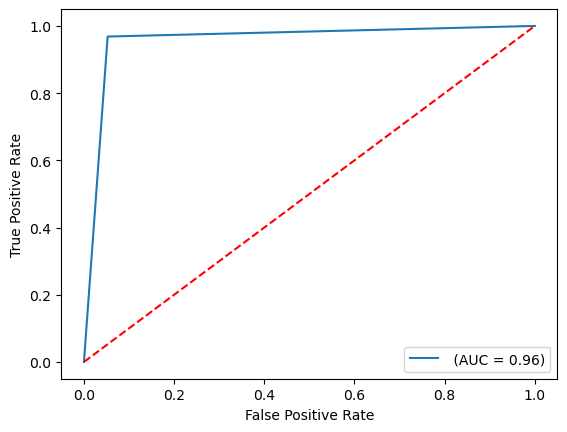

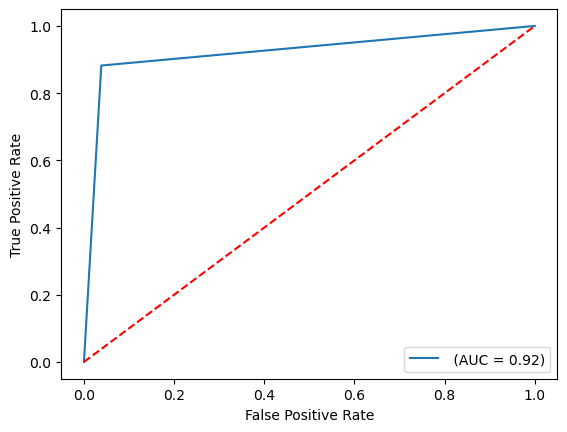

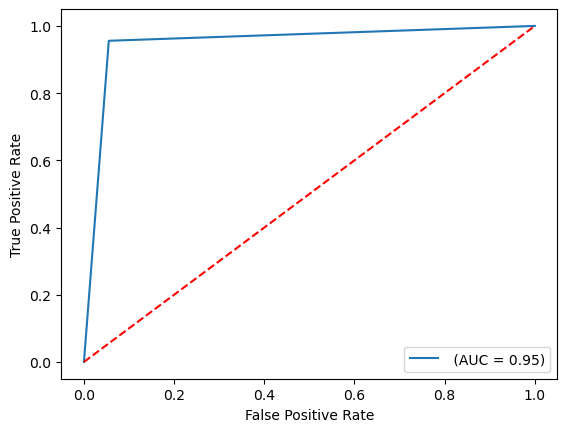

C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


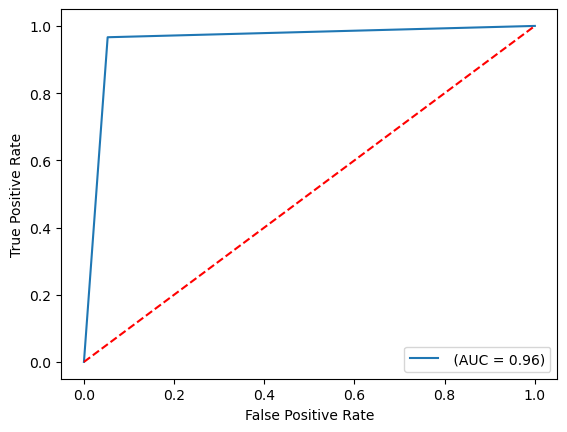

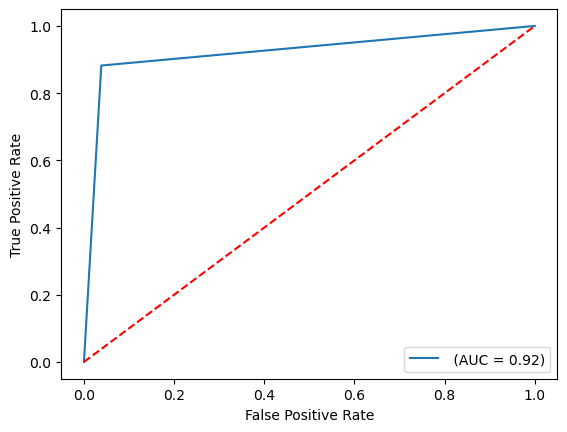

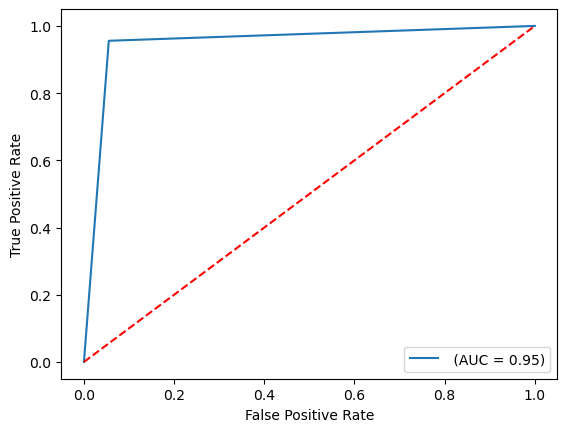

  Modelo Hiperparametro  Accuracy       AUC  Precision  Specificity    Recall  \
0  Logit             10  0.955378  0.957928   0.918164     0.980106  0.968421   
1    KNN              3  0.931474  0.921822   0.933185     0.930521  0.882105   
2    LDA             NA  0.949004  0.950331   0.913481     0.972296  0.955789   

        ECM  
0  0.044622  
1  0.068526  
2  0.050996  
  Modelo Hiperparametro  Accuracy       AUC  Precision  Specificity    Recall  \
0  Logit             10  0.954582  0.956876   0.918000     0.978808  0.966316   
1    KNN              3  0.931474  0.921822   0.933185     0.930521  0.882105   
2    LDA             NA  0.949004  0.950331   0.913481     0.972296  0.955789   

        ECM  
0  0.045418  
1  0.068526  
2  0.050996  


In [39]:
#Comparamos Logit con lambda = 1 (regularización lasso), Logit con lambda = 10 (regularización Ridge), Vecinos Cercanos, Análisis Discriminante Lineal
#Para eso llamamos dos veces a la función de evalua_multiples_metodos para especificar en cada una los dos Logits diferentes a utilizar.
penalty = 'l2'
k_knn = 3
hiperparametro = 10
K = 5
Ridge_multiples = evalua_multiples_metodos(K, X_train, X_test , Y_train, Y_test, X, Y, hiperparametro, k_knn,  modelos = ['Logit', 'KNN', 'LDA']
)

penalty = 'l1'
Lasso_multiples = evalua_multiples_metodos(K, X_train, X_test , Y_train, Y_test, X, Y, hiperparametro, k_knn,  modelos = ['Logit', 'KNN', 'LDA']
)

display(Ridge_multiples)
display(Lasso_multiples)

In [45]:
modelo = LogisticRegression(C=1/10, penalty='l2', solver="saga", max_iter=1000).fit(X_train, Y_train)

C:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Vemos en general que en todas las métricas todos los modelos tienen un desempeño muy alto. El modelo Logit con regularización tipo Ridge es el que mejor accuracy tiene (0.955), infimamente por encima del Logit con regularización Lasso (0.954) y LDA (0.949). Tambien es el que tiene más area debajo de la Curva ROC, es decir, el que más se aporixima a nuestra situación ideal de todos verdaderos positivos y negativos. En específico, 0.957 contra 0.956 y 0.95 de Logit con regularización Ridge y LDA. En cuanto a la precisión, el que mejor se desempeña es KNN (0.933). En relación a la especificidad, el modelo Logit con regularización Ridge vuelve a ser el mejor (0.980), infimamente superior al Logit con Lasso (0.978) y el LDA (0.972). En cuanto al Recall, el Logit con Ridge vuelve a destacar minimamente por encima de Logit con Lasso y LDA. En particual, un recall de 0.968 contra 0.966. Finalmente, con respecto al ECM, el Logit con Ridge es el que tiene el menor error cuadrático medio (0.0446), neuvamente levemente superior al Logit con Lasso (0.045) y LDA (0.050).

En conclusión, vemos que el Logit con regularización Ridge es el mejor modelo, tiene mejor performance en 5/6 de las metricas que elegimos. 

9. Con el m ́etodo que seleccionaron, predigan qu ́e personas son pobres dentro de
la base norespondieron. ¿Qu ́e proporci ́on de los hogares son pobres en esa
submuestra?

In [46]:
X_int_9 = norespondieron.copy()
X_9 = sm.add_constant(X_int_9) 

#Escalamos los datos para evitar un problema de convergencia que tiene el código. 
scaler = StandardScaler()
X_scaled_9 = scaler.fit_transform(X_9)  


#Usamos el modelo logit anteriormente definido pero con la matriz de predictores


y_test_pred_9 = modelo.predict(X_scaled_9)

# Convertimos las probabilidades en Y con valores 1 o 0 (usando el clasificador de Bayes)
y_pred_9 = np.where(y_test_pred_9 > 0.5, 1, y_test_pred_9)
y_pred_9 = np.where(y_test_pred_9 <= 0.5, 0, y_test_pred_9)
                    
#Calculamos las proporciones
prop_pob = (y_pred_9 == 1).mean()
prop_no_pob = (y_pred_9 == 0).mean()

print(prop_pob)

0.047575894879927506


Vemos que el modelo predice muy mal. Probamos predecir con Analisis discrimante lineal y los resultados mejoran a 15% pero lejos aun del 30% de hogares pobres que muestra el INDEC y mas aún del 37% que calculamos en la PARTE I del trabajo. Con respecto al pésimo desempeño del modelo, hay dos hipotesis. 

La primera, es que hay un problema en el código que no pudimos detectar y que no sea un error y que arruine el desempeño del modelo (ya sea propio del punto 8) o antes con respecto al tratamiento de la base, variables, defincion de variables, entre otros. 

El segundo, es que el modelo tenga un problema de overfitting. Es decir, el modelo es muy efectivo dentro de la muestra y la performance es muy buena, pero cuando vamos fuera de esta, los predictores esten sesgados, la varianza que genera muy alta y por lo tanto, la perfomance sea muy mala. En simples palabras, que este overfitting genera que el modelo, no sirva para nada. 